# OECD data

## Python setup

### Imports

In [1]:
# system imports
from pathlib import Path
from typing import Sequence, cast

# analytic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ABS
from henderson import hma
from matplotlib.lines import Line2D

# local imports
from plotting import finalise_plot, set_chart_dir

### Settings

In [2]:
# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use("fivethirtyeight")

# multi-time-period charts
TODAY = pd.Timestamp("today")
RECENCY_PERIOD = 6  # years
MONTH_ADJ = 3  # months
RECENT = TODAY - pd.DateOffset(years=RECENCY_PERIOD, months=MONTH_ADJ)

# Other
SOURCE = "Source: OECD"

# Where to put the charts
CHART_DIR = "./CHARTS/OECD"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
set_chart_dir(CHART_DIR)

# Remove old charts
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()

# display charts in notebook
SHOW = True

## OECD support

### Data

In [3]:
location_map = {
    "AUS": "Australia",
    "AUT": "Austria",
    "BEL": "Belgium",
    "CAN": "Canada",
    "CHL": "Chile",
    "CZE": "Czech Rep.",
    "DNK": "Denmark",
    "EST": "Estonia",
    "FIN": "Finland",
    "FRA": "France",
    "DEU": "Germany",
    "GRC": "Greece",
    "HUN": "Hungary",
    "ISL": "Iceland",
    "IRL": "Ireland",
    "ISR": "Israel",
    "ITA": "Italy",
    "JPN": "Japan",
    "KOR": "Korea",
    "LVA": "Latvia",
    "LUX": "Luxembourg",
    "MEX": "Mexico",
    "NLD": "Netherlands",
    "NZL": "New Zealand",
    "NOR": "Norway",
    "POL": "Poland",
    "PRT": "Portugal",
    "SVK": "Slovak Rep.",
    "SVN": "Slovenia",
    "ESP": "Spain",
    "SWE": "Sweden",
    "CHE": "Switzerland",
    "TUR": "Turkey",
    "GBR": "United Kingdom",
    "USA": "United States",
    "ARG": "Argentina",
    "BRA": "Brazil",
    "CHN": "China",
    "COL": "Colombia",
    "CRI": "Costa Rica",
    "IND": "India",
    "IDN": "Indonesia",
    "LTU": "Lithuania",
    "RUS": "Russia",
    "SAU": "Saudi Arabia",
    "ZAF": "South Africa",
}

In [4]:
def get_chart_groups() -> dict[str, list[str]]:
    """Get chart groups, with no more than 6 lines
    per chart."""

    of_interest = ["AUS", "USA", "CAN", "DEU", "GBR", "JPN"]
    anglosphere = ["AUS", "USA", "CAN", "NZL", "GBR", "IRL"]
    major_europe = ["FRA", "DEU", "ITA", "GBR", "RUS", "ESP"]
    largest_economies = ["USA", "CHN", "JPN", "DEU", "GBR", "IND"]
    asia = ["KOR", "JPN", "CHN", "IND", "IDN"]
    north_europe = ["DNK", "SWE", "NOR", "ISL", "FIN", "GBR"]
    baltic_europe = ["LVA", "LTU", "EST"]
    central_europe = ["CZE", "HUN", "SVK", "SVN", "POL", "GRC"]
    west_europe = ["BEL", "ESP", "PRT", "NLD", "LUX", "FRA"]
    italo_germanic_europe = ["DEU", "AUT", "CHE", "ITA"]
    n_america = ["USA", "CAN", "MEX"]
    c_s_america = ["CHL", "ARG", "BRA", "COL", "CRI"]
    other = ["AUS", "NZL", "SAU", "ZAF", "ISR"]

    charts = {
        "of_interest": of_interest,
        "anglosphere": anglosphere,
        "major_europe": major_europe,
        "largest_economies": largest_economies,
        "asia": asia,
        "north_europe": north_europe,
        "baltic_europe": baltic_europe,
        "central_europe": central_europe,
        "west_europe": west_europe,
        "italo_germanic_europe": italo_germanic_europe,
        "n_america": n_america,
        "c_s_america": c_s_america,
        "other": other,
    }

    return charts


chart_sets = get_chart_groups()

### Python functions

In [5]:
def get_from_oecd(sdmx_query, start: str | None = None) -> pd.DataFrame:
    url = f"https://stats.oecd.org/SDMX-JSON/data/{sdmx_query}?contentType=csv"
    if start is not None:
        url = f"{url}&startTime={start}"
    return pd.read_csv(url)

In [6]:
def build_query(resource, locations, subject, measure, frequency):
    if frequency:
        key = [locations, subject, measure, frequency]
    else:
        key = [locations, subject, measure]
    key_string = f"{'.'.join(['+'.join(x) for x in key])}"
    return f"{resource}/{key_string}"

In [7]:
def annualise_percentages(
    data: pd.Series | pd.DataFrame, periods: int = 12
) -> pd.Series | pd.DataFrame:
    """Annualise a growth rate for a period."""

    s = data / 100.0
    annualised = (((1 + s) ** periods) - 1) * 100
    return annualised

In [8]:
def percent_change(
    data: pd.Series | pd.DataFrame, periods: int
) -> pd.Series | pd.DataFrame:
    """Calculate an n-periods percentage change."""

    return (data / data.shift(periods) - 1) * 100

## OECD Unemployment Rates

### Get UE data

In [9]:
def get_uer_data() -> tuple[pd.DataFrame, str]:
    """Capture UE data from OECD data lake.
    Returns a DataFrame and a string description
    of the data source."""

    # data identifiers - seasonally adjusted monthly unemployment rates
    resource_id = "STLABOUR"  # Short-term labour
    subject = "LRHUTTTT"  # Monthly unemployment rate all persons, sa
    measure = "STSA"
    rfooter = f"Source: OECD {resource_id} {subject} {measure}"

    # capture monthly, then quarterly if no monthly data
    uer_loc_map = tuple(location_map.keys())
    uer = pd.DataFrame()
    for period in ("M", "Q"):  # Monthly must be first
        query = build_query(resource_id, uer_loc_map, [subject], [measure], [period])
        data = get_from_oecd(query, start="2017").pivot(
            values="Value", index="TIME", columns="LOCATION"
        )
        data.index = pd.PeriodIndex(data.index, freq=period)
        data = data.sort_index()

        if period == "Q":
            data = data.resample("M").interpolate()
        uer[data.columns] = data[data.columns]

        # set up second round
        uer_loc_map = tuple(set(uer_loc_map) - set(data.columns))

    return uer, rfooter


uer_data, uer_rfooter = get_uer_data()
uer_data.tail()

,AUS,AUT,BEL,CAN,CHL,COL,CRI,CZE,DEU,DNK,ESP,EST,FIN,FRA,GBR,GRC,HUN,IRL,ISL,ISR,ITA,JPN,KOR,LTU,LUX,LVA,MEX,NLD,NOR,POL,PRT,SVK,SVN,SWE,TUR,USA,CHE,NZL
TIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-07,3.740654,5.7,5.3,5.5,8.653333,9.345486,8.816237,2.7,3.0,5.5,12.0,7.5,7.4,7.4,NaN,11.3,4.0,4.4,3.5,3.370091,7.8,2.7,2.8,6.3,5.2,6.6,2.925703,3.6,3.6,2.8,6.3,5.8,3.8,7.1,9.3,3.5,4.124191,3.9
2023-08,3.700706,5.4,5.3,5.5,8.677360,9.551893,8.097805,2.5,3.0,4.3,11.9,7.3,7.3,7.4,NaN,10.8,4.0,4.5,3.5,3.163448,7.5,2.7,2.4,6.7,5.3,6.6,2.754729,3.6,3.6,2.8,6.3,5.8,3.8,8.1,9.1,3.8,4.124191,3.9
2023-09,3.552046,5.5,5.4,5.5,8.834496,9.709428,7.690094,2.7,3.1,4.7,12.0,6.5,7.4,7.3,NaN,10.3,3.9,4.7,3.5,3.205076,7.6,2.6,2.6,6.9,5.5,6.5,2.691792,3.7,3.5,2.8,6.6,5.8,3.9,8.2,9.0,3.8,4.124191,3.9
2023-10,3.750807,5.1,5.6,5.7,NaN,10.165670,NaN,2.9,3.1,5.4,12.0,6.3,7.5,7.3,NaN,9.6,4.1,4.8,3.5,3.056716,7.8,2.5,2.5,6.5,5.5,6.5,2.662356,3.6,3.6,2.8,6.7,5.8,4.1,7.9,8.5,3.9,NaN,NaN
2023-11,3.857026,NaN,NaN,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7,NaN,NaN


### Plot UR Rates 

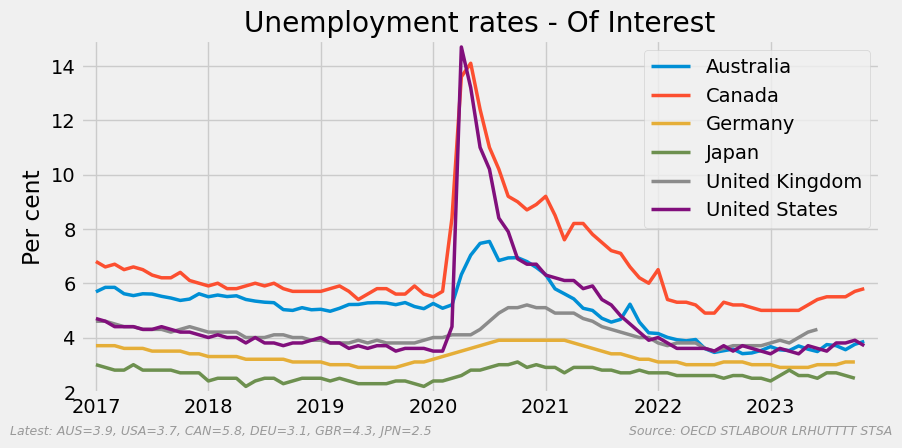

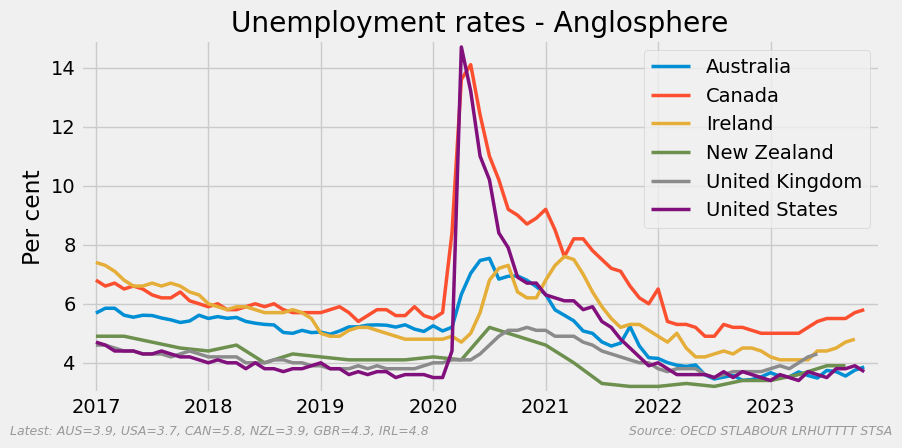

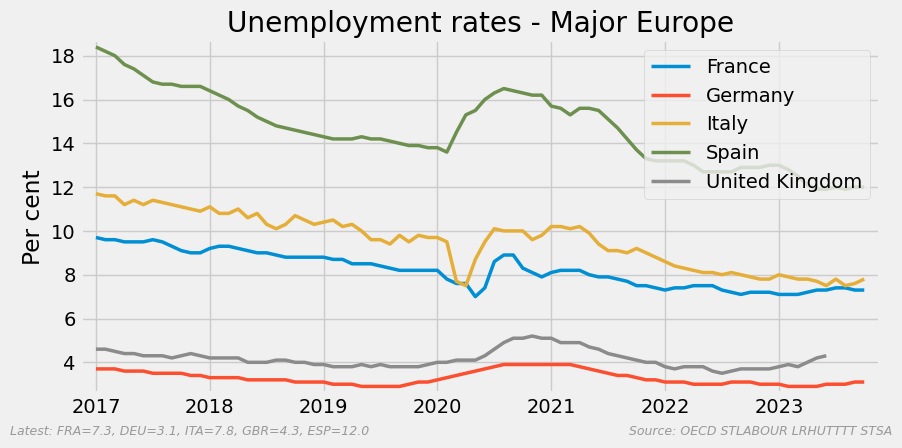

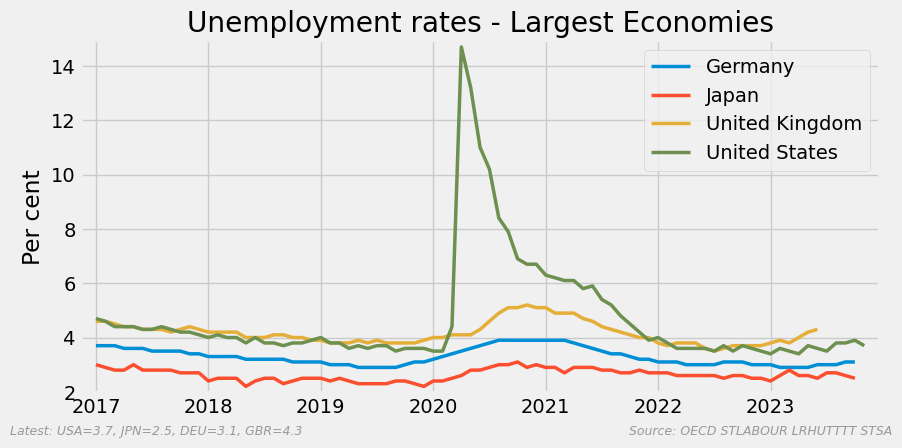

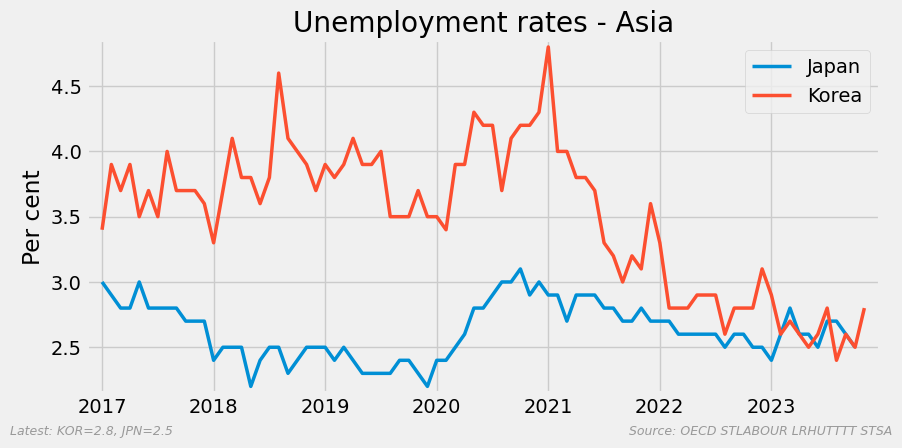

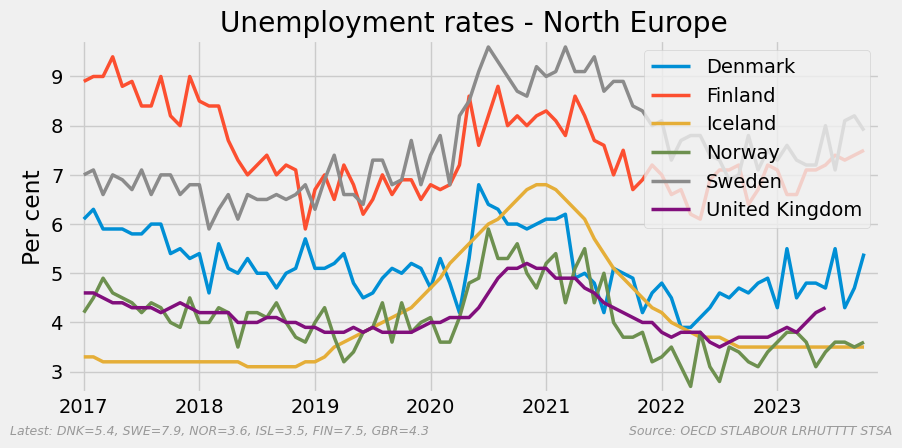

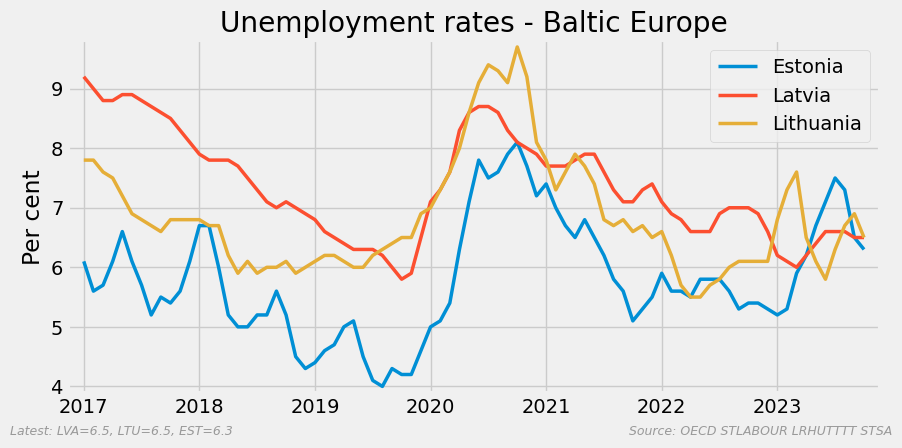

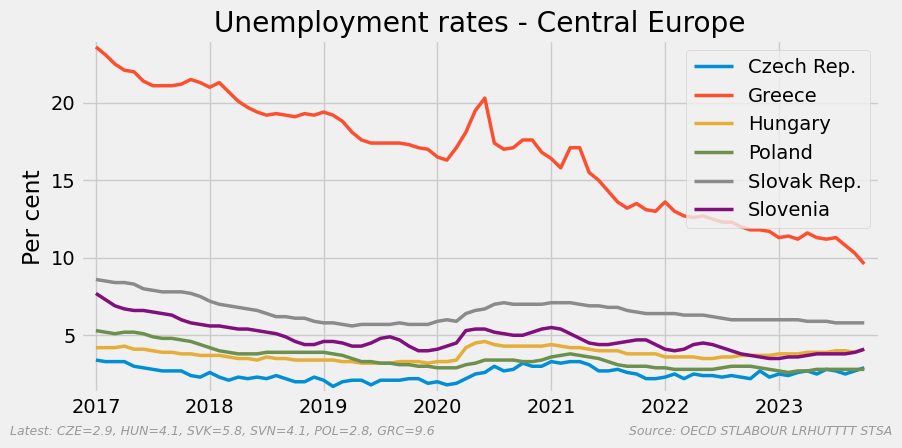

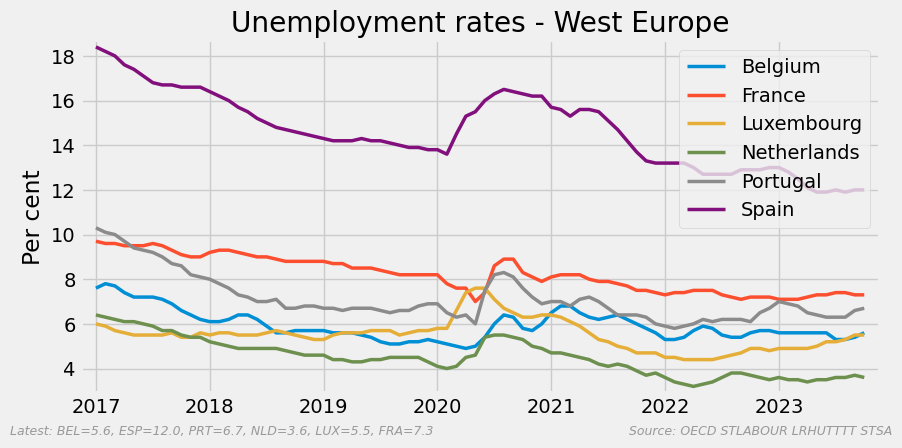

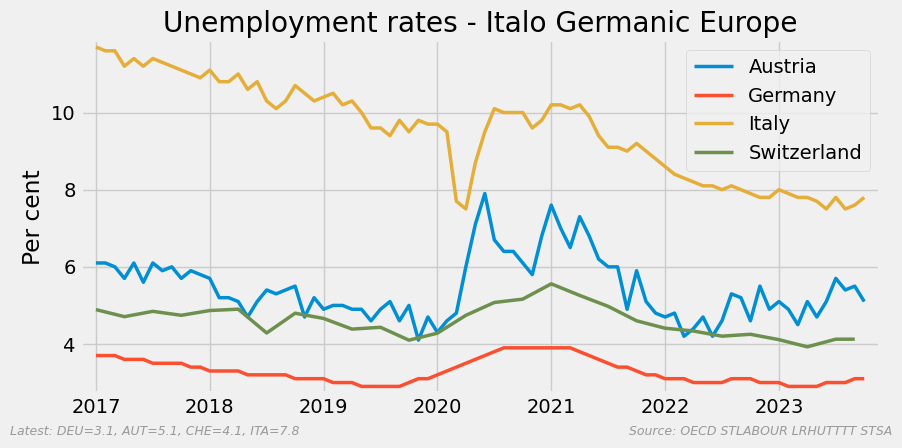

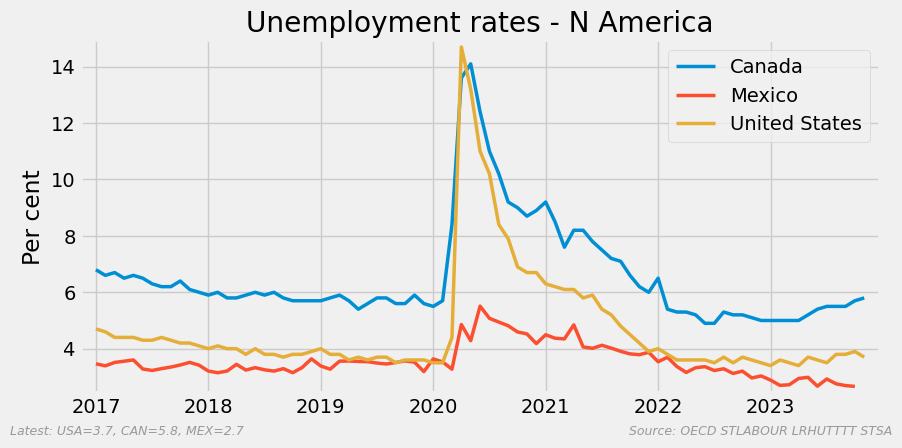

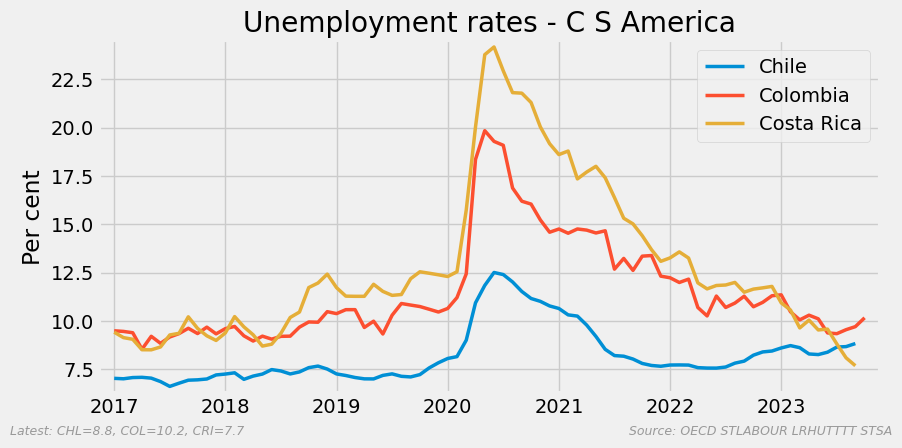

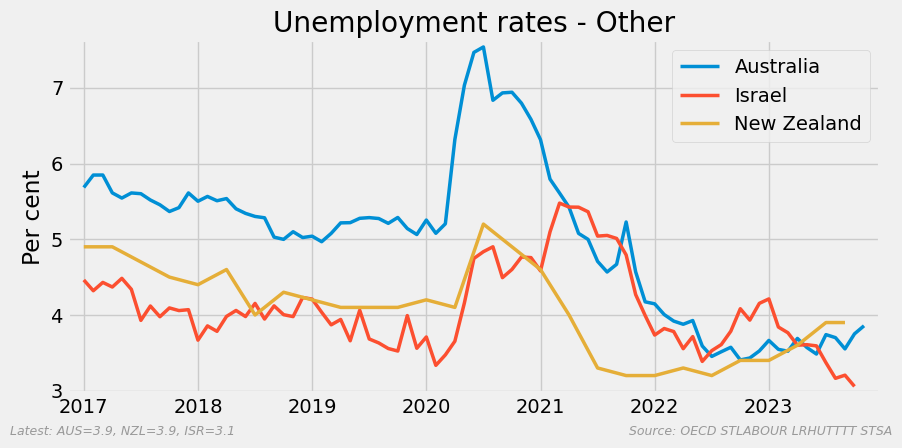

In [10]:
def plot_uer():
    for charset in chart_sets:
        chart_set = chart_sets[charset]
        endpoints = [
            f"{x}={uer_data[x].dropna().round(1).iloc[-1]}"
            for x in chart_set
            if x in uer_data.columns
        ]
        lfooter_ur = f"Latest: {', '.join(endpoints)}"

        ax = (
            uer_data[[x for x in chart_set if x in uer_data.columns]]
            .rename(columns=location_map)
            .sort_index(axis=1)
            .plot(lw=2.5)
        )
        finalise_plot(
            ax,
            title=f"Unemployment rates - {charset.replace('_', ' ').title()}",
            ylabel="Per cent",
            rfooter=uer_rfooter,
            lfooter=lfooter_ur,
            show=SHOW,
        )


plot_uer()

In [11]:
# set a threshold for establishing an OECD mean
print("Data available: \n", uer_data.notna().sum(axis=1).tail())
MIN_UER_REQUIREMENT = 33

Data available: 
 TIME
2023-07    37
2023-08    37
2023-09    37
2023-10    33
2023-11     4
Freq: M, dtype: int64


### Australian UER vs OECD Average

In [12]:
# To do

## OECD GDP data

### Real GDP growth

In [13]:
def get_rgdp() -> tuple[pd.DataFrame, pd.DataFrame, str]:
    """Get real GDP data from the OECD."""

    # rGDP - get the data
    resource_id = "QNA"  # Quarterly National Accounts
    measure = "VPVOBARSA"  # US dollars, volume estimates, fixed PPPs,
    # OECD reference year, annual levels,
    # seasonally adjusted
    subject = "B1_GE"  # Gross domestic product - expenditure approach
    rfooter = f"Source: OECD {resource_id} {subject} {measure}"
    lfooter = "Volume est., US$, fixed PPPs, Seas Adj"

    query = build_query(resource_id, location_map, [subject], [measure], ["Q"])
    rgdp = get_from_oecd(query, start="1959").pivot(
        values="Value", index="TIME", columns="LOCATION"
    )
    rgdp.index = pd.PeriodIndex(rgdp.index, freq="Q")
    rgdp_qtr_growth = pd.DataFrame(percent_change(rgdp, 1))  # mypy type cast
    rgdp_qtr_growth.tail()

    return rgdp, rgdp_qtr_growth, rfooter


rgdp, rgdp_qtr_growth, rgdp_rfooter = get_rgdp()
rgdp_qtr_growth.tail()

LOCATION,ARG,AUS,AUT,BEL,BRA,CAN,CHE,CHL,COL,CRI,CZE,DEU,DNK,ESP,EST,FIN,FRA,GBR,GRC,HUN,IDN,IND,IRL,ISL,ISR,ITA,JPN,KOR,LTU,LUX,LVA,MEX,NLD,NOR,NZL,POL,PRT,RUS,SAU,SVK,SVN,SWE,TUR,USA,ZAF
TIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022Q3,0.359296,0.204363,-0.164829,0.313006,1.052323,0.458010,0.245312,-1.134194,0.903627,1.172693,-0.225672,0.361414,0.418825,0.530634,-0.506047,-0.054444,0.497430,-0.078187,0.519208,-1.110253,0.798896,1.982570,3.487708,-2.228688,0.648810,0.301092,-0.096010,0.233725,0.653710,0.240258,-0.651763,1.218743,0.170190,1.900359,2.100730,0.617203,0.491293,NaN,1.231845,0.342821,-0.112230,0.781436,0.542207,0.658619,1.773956
2022Q4,-1.691144,0.854938,-0.109462,0.242595,-0.116739,-0.215344,-0.026670,0.134975,-1.636138,2.154761,-0.391729,-0.406273,0.265231,0.491225,-1.436316,-0.546470,-0.001407,0.103799,0.914758,-0.836048,2.336996,1.140989,-1.578874,2.697422,1.079971,-0.150094,0.248074,-0.302966,-0.451993,-2.315748,0.645999,0.677672,0.686298,-0.669131,-0.990936,-2.276954,0.508477,NaN,1.164422,0.234247,0.608573,-0.847339,1.148543,0.635422,-1.094061
2023Q1,0.809382,0.533363,0.091308,0.413038,1.439727,0.610026,0.309544,0.546971,2.171743,0.601065,0.087157,-0.000005,1.061146,0.571947,-0.777552,0.029095,0.059125,0.253156,0.050324,-0.245232,0.837337,2.080532,-1.878232,1.257146,0.760059,0.568414,1.227394,0.329872,-1.855364,0.852667,-0.474166,0.570310,-0.494665,0.214569,-0.645515,1.101975,1.470816,NaN,-1.116415,0.197028,0.157451,0.500842,-0.252100,0.556380,0.406613
2023Q2,-2.727763,0.438746,-1.109172,0.332988,0.984869,0.338964,-0.127102,-0.348748,-0.988242,1.702031,0.110628,0.139073,-0.920581,0.436650,-0.600516,0.345665,0.614370,0.037754,1.102526,-0.029898,0.866410,1.887501,-0.364485,1.599376,0.813119,-0.376757,0.880415,0.608655,2.447922,-0.185081,-0.306039,0.934632,-0.444704,-0.513446,0.862009,0.295513,0.136666,NaN,-0.505201,0.437179,0.993703,-0.806939,3.306437,0.511122,0.457336
2023Q3,2.723691,0.211975,-0.518949,0.402334,0.144538,-0.266630,0.270638,0.331249,0.238777,1.326593,-0.525715,-0.129622,-0.072298,0.302290,-1.293734,-0.856059,-0.114727,-0.128844,0.015572,0.855188,0.809229,1.736145,-1.911116,-3.753676,0.702553,0.098864,-0.728690,0.616075,-0.020846,-0.143515,0.172123,1.070123,-0.307952,-0.523183,-0.711937,1.488772,-0.238709,NaN,-3.176127,0.246495,-0.157113,-0.294406,0.272529,1.193871,-0.247536


In [14]:
# check for missing data in the final period ...
final_row = rgdp.iloc[-1]
missing_count = final_row.isna().sum()
if missing_count:
    print(f"Final period: {final_row.name}")
    print(f"Missing data count for final period: {missing_count}")
    print(f"Missing data belongs to: {rgdp.columns[final_row.isna()].to_list()}")
    print(f"Nations with final data: {rgdp.columns[final_row.notna()].to_list()}")

Final period: 2023Q3
Missing data count for final period: 1
Missing data belongs to: ['RUS']
Nations with final data: ['ARG', 'AUS', 'AUT', 'BEL', 'BRA', 'CAN', 'CHE', 'CHL', 'COL', 'CRI', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IDN', 'IND', 'IRL', 'ISL', 'ISR', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'NZL', 'POL', 'PRT', 'SAU', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'ZAF']


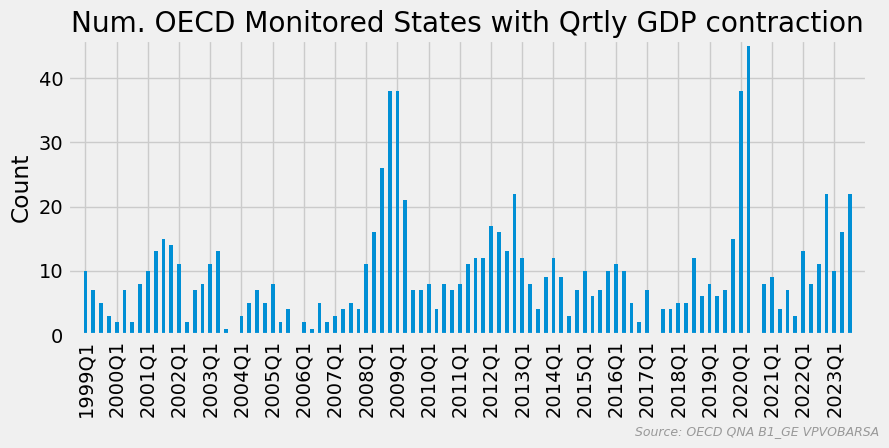

Latest N=22
Austria, Canada, Czech Rep., Germany, Denmark, Estonia, Finland, France, United Kingdom, Ireland, Iceland, Japan, Lithuania, Luxembourg, Netherlands, Norway, New Zealand, Portugal, Saudi Arabia, Slovenia, Sweden, South Africa


In [15]:
def plot_contractions():
    # GDP identify/count quarterly contractions
    contractions = rgdp_qtr_growth < 0
    contraction_count = contractions.sum(axis=1)

    start = pd.Period("1999Q1", freq="Q")
    title = "Num. OECD Monitored States with Qrtly GDP contraction"
    ax = contraction_count[contraction_count.index >= start].plot.bar()
    ax.set_xticks(ax.get_xticks()[::4])
    finalise_plot(
        ax,
        title=title,
        ylabel="Count",
        rfooter=rgdp_rfooter,
        show=SHOW,
    )

    # print nations in contraction
    print(f"Latest N={contraction_count.iloc[-1]}")
    print(
        ", ".join(
            [
                location_map[x]
                for x in contractions.iloc[-1][contractions.iloc[-1]].index
            ]
        )
    )


plot_contractions()

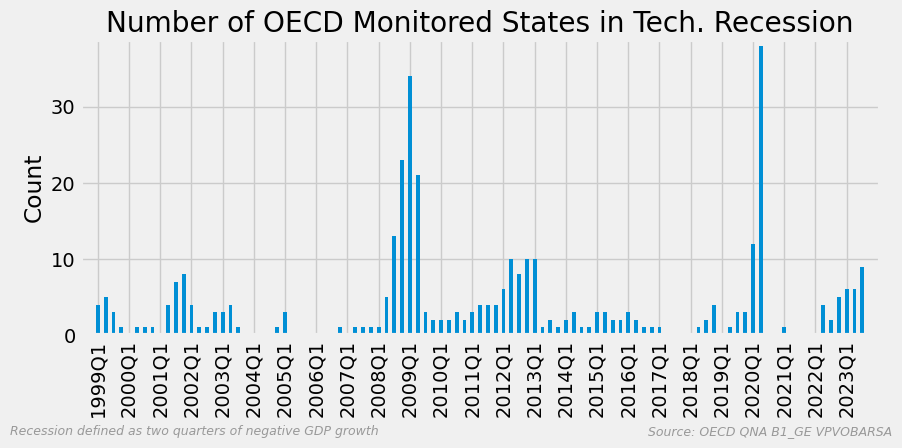

Latest N=9
Austria, Denmark, Estonia, Ireland, Luxembourg, Netherlands, Norway, Saudi Arabia, Sweden


In [16]:
def plot_recessions():
    """GDP identify/count technical recessions."""

    recessions = (rgdp_qtr_growth < 0) & (rgdp_qtr_growth.shift(1) < 0)
    recession_count = recessions.sum(axis=1)

    title = "Number of OECD Monitored States in Tech. Recession"
    start = pd.Period("1999Q1", freq="Q")
    ax = recession_count[recession_count.index >= start].plot.bar()
    ax.set_xticks(ax.get_xticks()[::4])
    finalise_plot(
        ax,
        title=title,
        ylabel="Count",
        rfooter=rgdp_rfooter,
        lfooter="Recession defined as two quarters of negative GDP growth",
        show=SHOW,
    )

    # print nations in contraction
    print(f"Latest N={recession_count.iloc[-1]}")
    print(
        ", ".join(
            [location_map[x] for x in recessions.iloc[-1][recessions.iloc[-1]].index]
        )
    )


plot_recessions()

## OECD inflation data

In [17]:
def get_cpi(measure: str = "GY") -> pd.DataFrame:
    """Get CPI data from OECD.
    Measure is either "GY" for annual growth, or
    "IXOB" for the raw index."""

    # data reference
    resource_id = "PRICES_CPI"
    subject_tuple = ("CP18ALTT", "CPALTT01")
    rfooter = f"Source: OECD {resource_id} {subject_tuple} {measure}"

    # drop problematic states
    cpi_locs = tuple(location_map.keys())

    # capture monthly, then quarterly if no monthly data
    cpi = pd.DataFrame()
    for period in ("M", "Q"):  # Monthly must be first
        for subject in subject_tuple:
            query = build_query(resource_id, cpi_locs, [subject], [measure], [period])
            data = get_from_oecd(query, start="2000")
            data = data.pivot(values="Value", index="TIME", columns="LOCATION")
            data.index = pd.PeriodIndex(data.index, freq=period)
            data = data.sort_index()

            if period == "Q":
                data = data.resample(rule="M", convention="end").interpolate()
                data = data.reindex(cpi.index, fill_value=np.nan)
            cpi[data.columns] = data[data.columns]

            # set up next round
            cpi_locs = tuple(set(cpi_locs) - set(data.columns))

    cpi.columns = cpi.columns.map(location_map)
    return cpi

In [18]:
# Get/create key CPI data
cpi = get_cpi(measure="IXOB")  # index
annual = pd.DataFrame(percent_change(cpi, 12))  # growth rate
quarterly = pd.DataFrame(percent_change(cpi, 3))  # growth rate
quarterly_annualised = pd.DataFrame(annualise_percentages(quarterly, 4))  # rate

# smoothed / trend data
HENDERSON = 13
annual_smooth_d = {}
qa_smooth_d = {}
for nation in annual.columns:
    annual_smooth_d[nation] = hma(annual[nation].dropna(), HENDERSON)
    qa_smooth_d[nation] = hma(quarterly_annualised[nation].dropna(), HENDERSON)
annual_smooth = pd.DataFrame(annual_smooth_d)
qa_smooth = pd.DataFrame(qa_smooth_d)

In [19]:
# some useful constants
START_COVID = pd.Period("2017-01-01", freq="M")
HIGH_COVID = pd.Period("2021-01-01", freq="M")
EXCLUDE = ["Turkey", "Russia"]
# Turkey has rampant inflation
# Russia not updating data during war

### CPI over the past year

In [20]:
# chart an inflation rate target
LOWER_IR, UPPER_IR = 2, 3
TARGET = {
    "ymin": LOWER_IR,
    "ymax": UPPER_IR,
    "color": "#dddddd",
    "label": f"{LOWER_IR}-{UPPER_IR}% inflation target",
    "zorder": -1,
}
TARGET_V = TARGET | {"xmin": LOWER_IR, "xmax": UPPER_IR}
for remove in ("ymin", "ymax"):
    TARGET_V.pop(remove)

In [21]:
def get_recent_ohlc(data: pd.DataFrame) -> pd.DataFrame:
    """For a dataset, build a table of Open, Highm Low, Close
    points for last valid 13 months in each column."""

    # compare progress over 13 months because Australia
    # and New Zealand only collect CPI measures quarterly
    INCLUSIVE_YEAR = 13  # months
    index = ["Open", "High", "Low", "Close"]
    summary = pd.DataFrame([], index=index)  # return vehicle
    for name in data.columns:
        if name in EXCLUDE:
            continue
        column = data[name]
        last_valid = cast(pd.Period, column.last_valid_index())  # mypy cast
        year = pd.period_range(end=last_valid, periods=INCLUSIVE_YEAR)
        frame = column[year]
        open = frame.iloc[0]
        high = frame.max()
        low = frame.min()
        close = frame.iloc[-1]
        key = f"{name} {str(last_valid.year)[2:]}-{last_valid.month:02d}"
        summary[key] = pd.Series([open, high, low, close], index=index)
    summary = summary.T.sort_values("Close")
    return summary

In [22]:
def plot_ohlc(ohlc_df: pd.DataFrame, horizontal: bool = True, **kwargs) -> None:
    """Plot data in ohlc_df in a open-high-low-close style."""

    def xy(x, y):
        return (x, y) if horizontal else (y, x)

    def set_limits(ax: plt.Axes) -> None:
        minimum = min(0, ohlc_df["Low"].min())  # include zero
        maximum = ohlc_df["High"].max()
        adjustment = (maximum - minimum) * 0.025
        limits = minimum - adjustment, maximum + adjustment
        if horizontal:
            ax.set_xlim(*limits)
        else:
            ax.set_ylim(*limits)

    # canvass
    fig, ax = plt.subplots()

    # sort out chart orientation
    good, bad = "darkblue", "darkorange"  # for colour blindness
    bar = ax.barh if horizontal else ax.bar
    reference = "left" if horizontal else "bottom"
    range = ohlc_df["High"] - ohlc_df["Low"]
    open_marker = "^" if horizontal else "<"
    close_marker = "v" if horizontal else ">"
    color = [
        good if open > close else bad
        for open, close in zip(ohlc_df.Open, ohlc_df.Close)
    ]

    # plot
    bar(
        ohlc_df.index,
        range,
        **{reference: ohlc_df["Low"]},
        color=color,
        linewidth=1.0,
        edgecolor="black",
        label="Range of prints through the 13 months",
        alpha=0.15,
    )
    ax.plot(
        *xy(ohlc_df["Open"], ohlc_df.index),
        marker=open_marker,
        linestyle="None",
        label="First print in the 13 months",
        color=good,
        markersize=5,
    )
    ax.plot(
        *xy(ohlc_df["Close"], ohlc_df.index),
        marker=close_marker,
        linestyle="None",
        label="Last print in the 13 months",
        color=bad,
        markersize=5,
    )
    ax.tick_params(axis="both", which="major", labelsize="x-small")
    set_limits(ax=ax)
    if not horizontal:
        ax.set_xticklabels(ohlc_df.index, rotation=90)
    finalise_plot(ax, **kwargs)

In [23]:
def get_lim(df):
    adjust = (df["High"].max() - df["Low"].min()) * 0.02
    return min(0, df["Low"].min()) - adjust, df["High"].max() + adjust

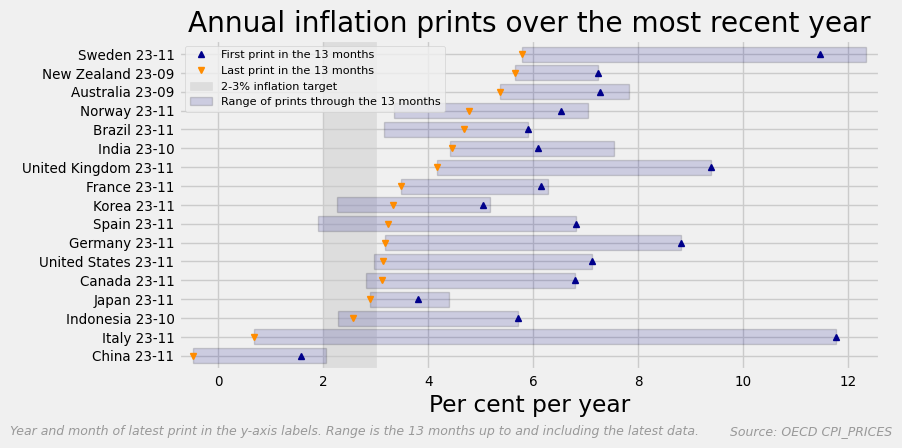

In [24]:
selected = [
    "Australia",
    "Canada",
    "China",
    "France",
    "Germany",
    "India",
    "Indonesia",
    "Italy",
    "Japan",
    "Korea",
    "United Kingdom",
    "United States",
    "New Zealand",
    "Norway",
    "Sweden",
    "Brazil",
    "Spain",
    "Turkey",
]
summary = get_recent_ohlc(annual[selected])

title_aip = "Annual inflation prints over the most recent year"
lfooter = (
    "Year and month of latest print in the y-axis labels. "
    "Range is the 13 months up to and including the latest data. "
)
plot_ohlc(
    summary,
    horizontal=True,
    title=title_aip,
    xlim=get_lim(summary),
    zero_y=True,
    xlabel="Per cent per year",
    tag="shorter",
    ylabel=None,
    axvspan=TARGET_V,
    legend={"loc": "best", "fontsize": "xx-small"},
    rfooter=f"{SOURCE} CPI_PRICES",
    lfooter=lfooter,
    show=SHOW,
)

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_89074/49996124.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ohlc_df.index, rotation=90)


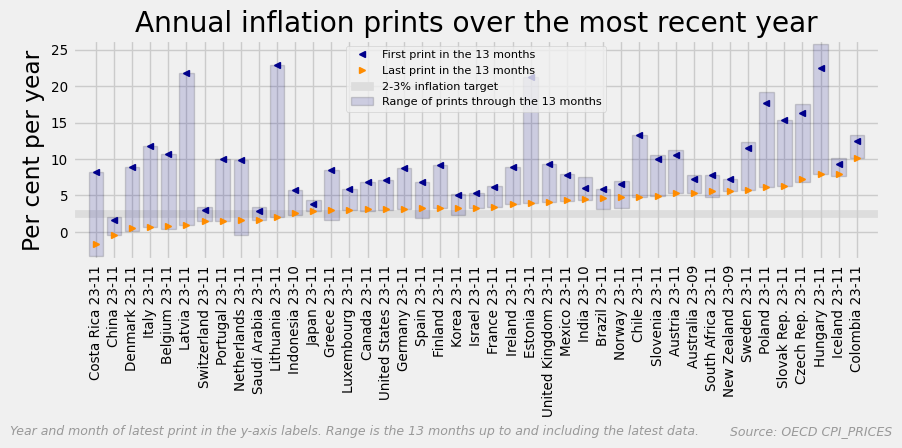

In [25]:
summary = get_recent_ohlc(annual)

# plot that dataset
plot_ohlc(
    summary,
    horizontal=False,
    title=title_aip,
    ylabel="Per cent per year",
    ylim=get_lim(summary),
    tag="longer",
    xlabel=None,
    axhspan=TARGET,
    legend={"loc": "best", "fontsize": "xx-small"},
    rfooter=f"{SOURCE} CPI_PRICES",
    lfooter=lfooter,
    show=SHOW,
)

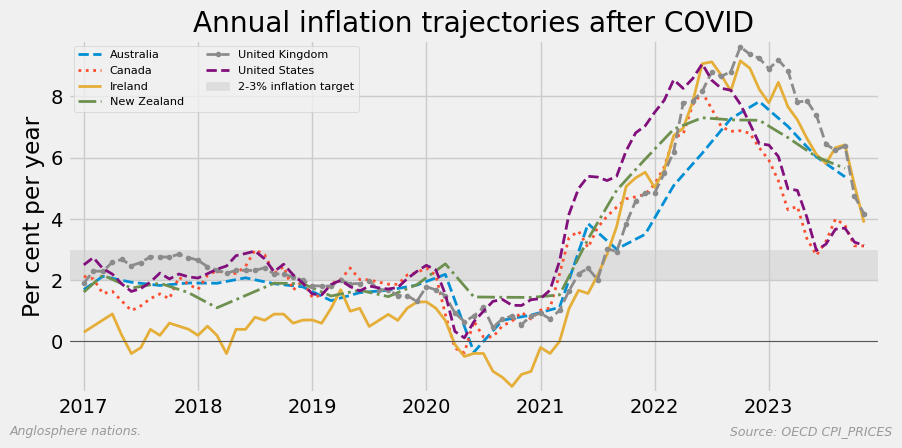

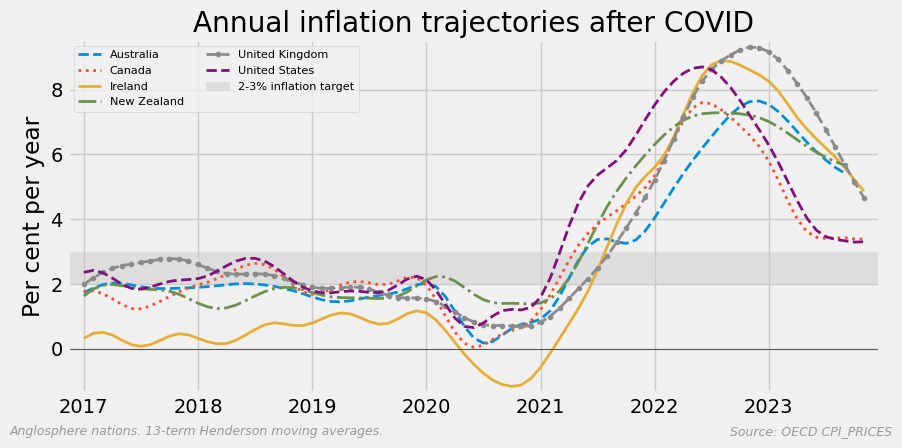

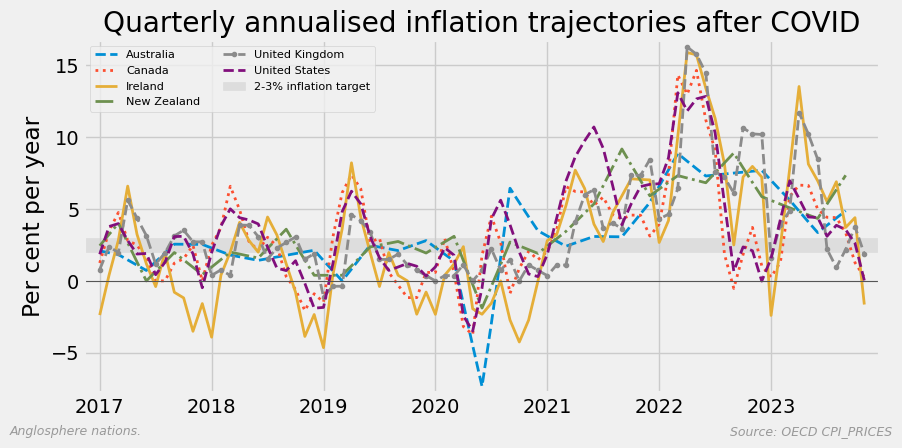

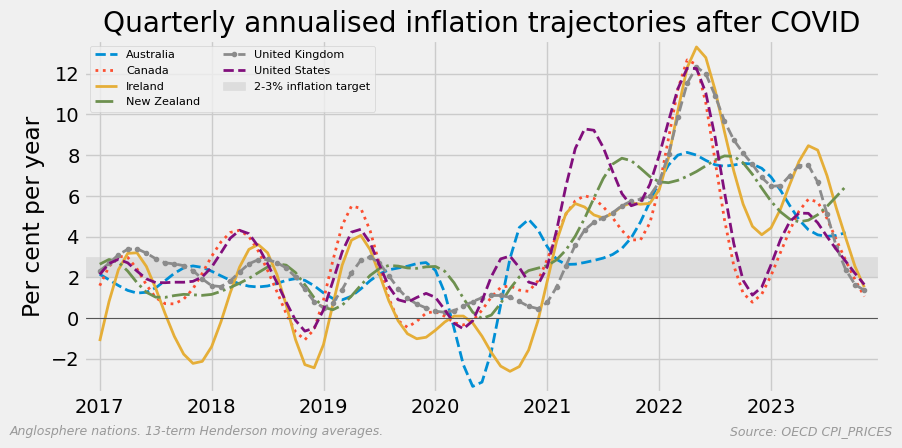

In [26]:
def plot_comparative() -> None:
    """An Anglo-sphere comparison."""

    anglo = sorted([location_map[x] for x in chart_sets["anglosphere"]])
    frames: Sequence[pd.DataFrame] = (
        annual[anglo],
        annual_smooth[anglo],
        quarterly_annualised[anglo],
        qa_smooth[anglo],
    )
    tags: Sequence[str] = ("raw", "smooth", "raw", "smooth")
    periods: Sequence[str] = (
        "Annual",
        "Annual",
        "Quarterly annualised",
        "Quarterly annualised",
    )
    style = [
        "--",
        ":",
        "-",
        "-.",
        "--.",
    ] * 2

    for frame, tag, period in zip(frames, tags, periods):
        time_limited = frame[frame.index >= START_COVID]
        axes = time_limited.plot(linewidth=2, style=style)
        lfooter = (
            f"{HENDERSON}-term Henderson moving averages. " if tag == "smooth" else ""
        )
        finalise_plot(
            axes,
            title=f"{period} inflation trajectories after COVID",
            xlabel=None,
            ylabel="Per cent per year",
            pre_tag=f"angloshpere-{tag}",
            axhspan=TARGET,
            legend={"ncols": 2, "loc": "best", "fontsize": "xx-small"},
            rfooter=f"{SOURCE} CPI_PRICES",
            lfooter=f"Anglosphere nations. {lfooter}",
            y0=True,
            show=SHOW,
        )


plot_comparative()

### Selected individual nations

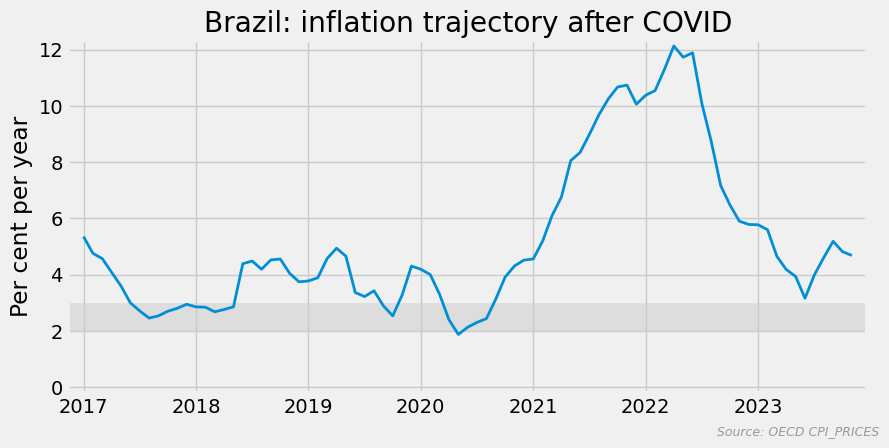

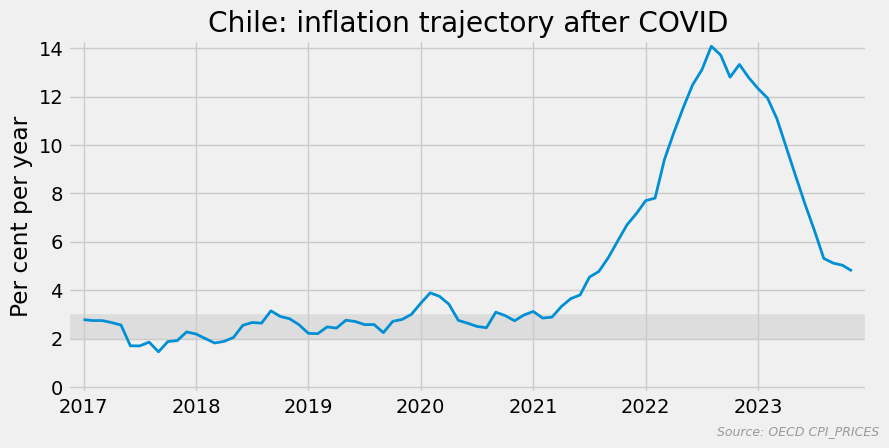

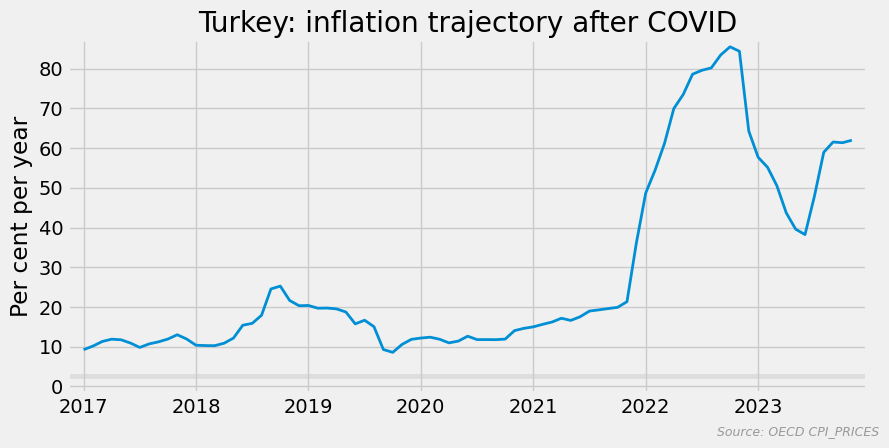

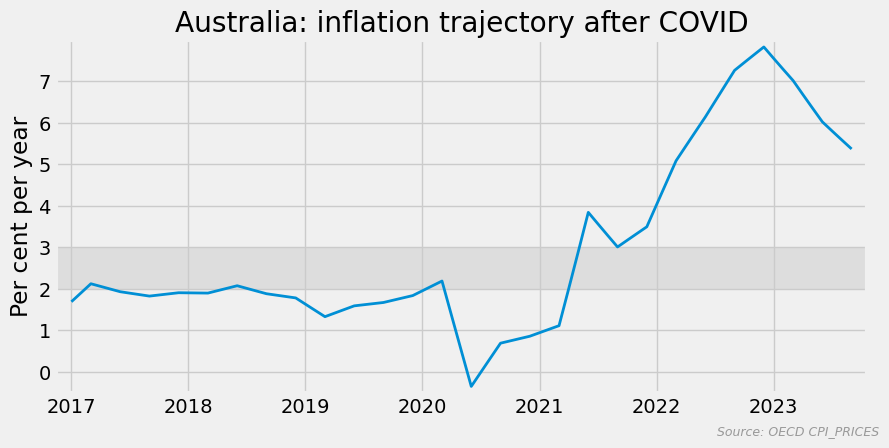

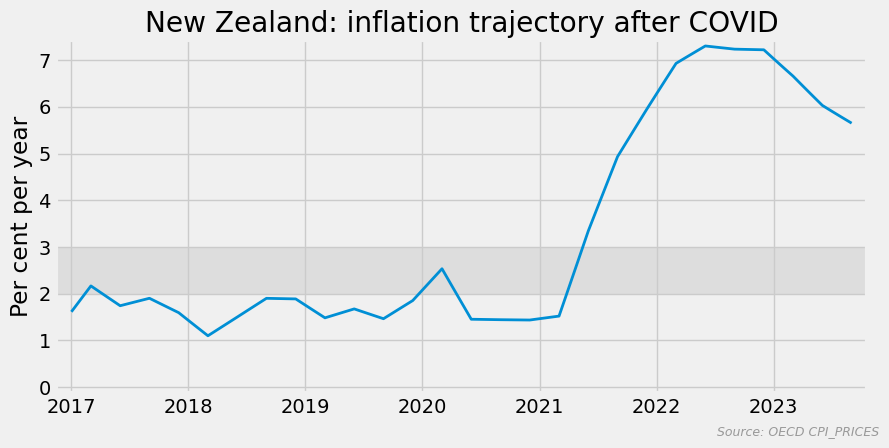

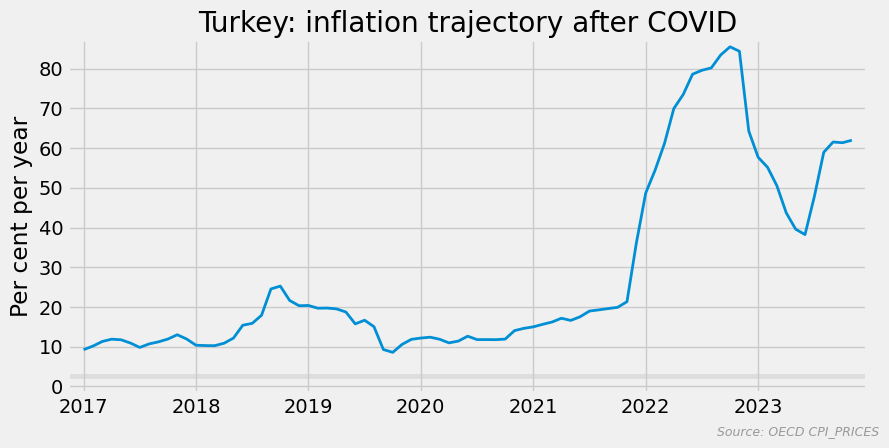

In [27]:
def plot_selected():
    """CPI plots for selected nations."""

    selected = (
        "Brazil",
        "Chile",
        "Turkey",
        "Australia",
        "New Zealand",
        "Turkey",
    )
    for select in selected:
        data = annual[select]
        ax = data[data.index >= START_COVID].plot(
            linewidth=2,
        )
        finalise_plot(
            ax,
            title=f"{select}: inflation trajectory after COVID",
            xlabel=None,
            ylabel="Per cent per year",
            axhspan=TARGET,
            pre_tag="national-inflation-",
            rfooter=f"{SOURCE} CPI_PRICES",
            zero_y=True,
            show=SHOW,
        )


plot_selected()

### Australia vs OECD monitored mean

In [28]:
def check():
    """Check missingness."""

    for check in (2, 1):
        selection = annual.iloc[-check]
        print(f"Reporting at N-{check} (incl. excludeds): {len(selection.dropna())}")

    print("Total nations after exclusions: " f"{len(annual.columns)-len(EXCLUDE)}")
    n_minus_2 = annual.iloc[-2]
    print(
        "Missing at N-2 (including excludeds): "
        f"{n_minus_2[n_minus_2.isna()].index.to_list()}"
    )


check()

# Pick a minimum number of data points before taking an OECD mean
# Note: Australia and NZ only report quarterly
MIN_MEAN_REQUIRED = 38  # allow some wriggle room

Reporting at N-2 (incl. excludeds): 42
Reporting at N-1 (incl. excludeds): 40
Total nations after exclusions: 43
Missing at N-2 (including excludeds): ['Russia', 'Australia', 'New Zealand']


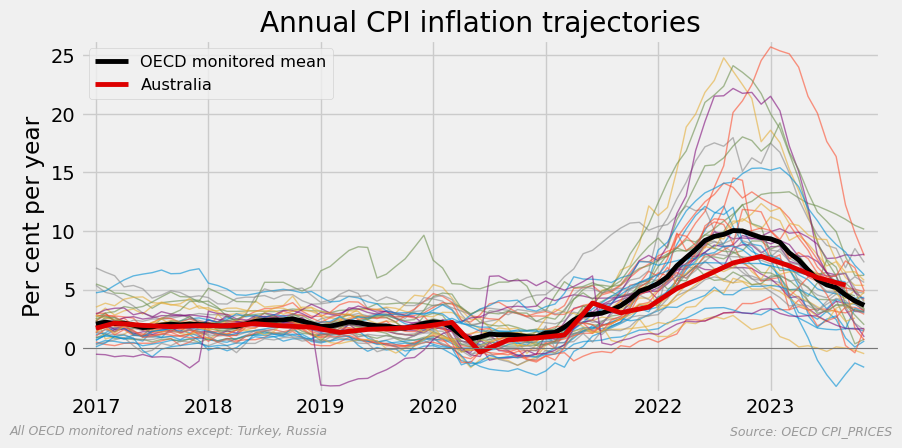

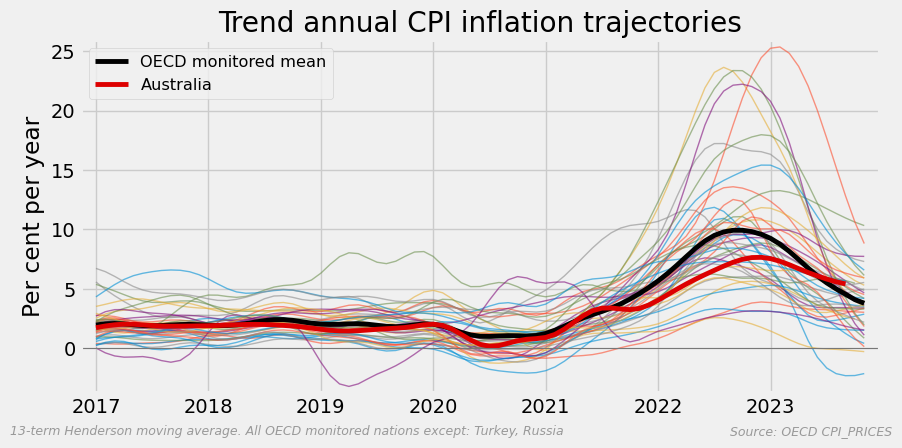

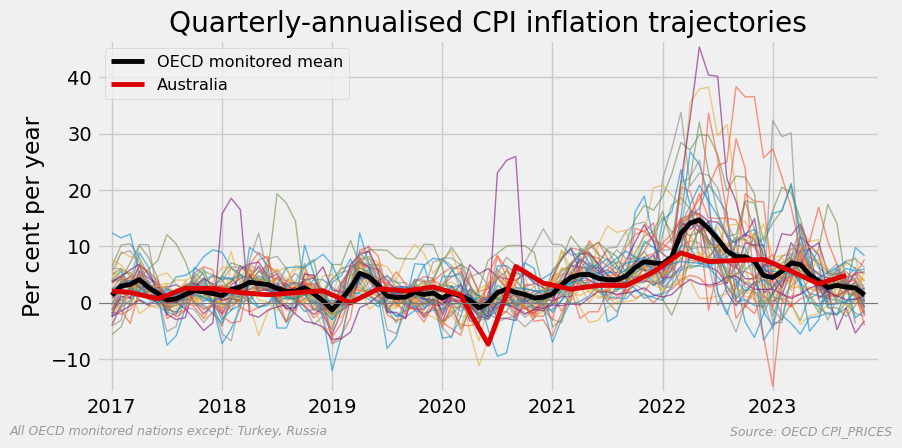

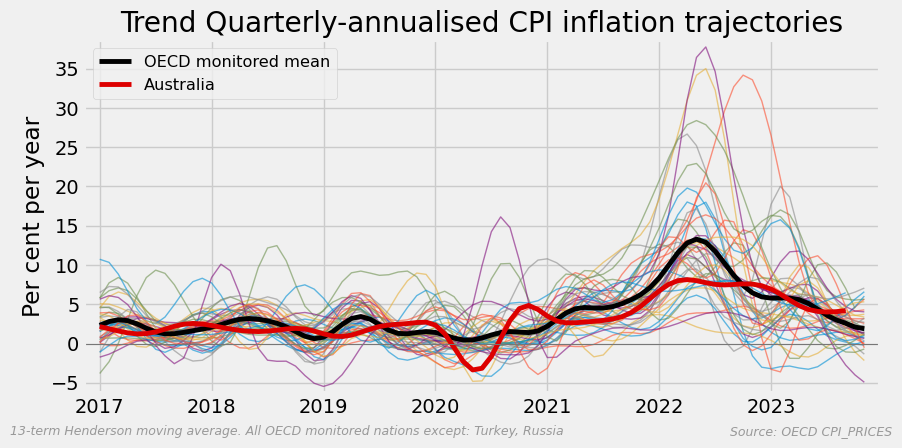

In [29]:
def cpi_comparative() -> None:
    """CPI comparative."""

    datasets = {
        "Annual": annual,
        "Trend annual": annual_smooth,
        "Quarterly-annualised": quarterly_annualised,
        "Trend Quarterly-annualised": qa_smooth,
    }

    for title, data in datasets.items():
        footer = (
            ""
            if "Trend" not in title
            else f"{HENDERSON}-term Henderson moving average. "
        )

        frame = data.drop(columns=EXCLUDE)
        frame = frame[frame.index >= START_COVID]
        ax = frame.plot(lw=1, alpha=0.6)
        ax.get_legend().remove()

        mean_color, aus_color, lw = "black", "#dd0000", 3.5
        mean = frame.dropna(axis=0, thresh=MIN_MEAN_REQUIRED).mean(axis=1)
        mean.plot(lw=lw, color=mean_color, label="Mean")

        frame["Australia"].plot(lw=lw, color=aus_color, label="Australia")
        custom_lines = [
            Line2D([0], [0], color=mean_color, lw=lw),
            Line2D([0], [0], color=aus_color, lw=lw),
        ]
        ax.legend(custom_lines, ["OECD monitored mean", "Australia"], fontsize="small")

        ax.axhline(0, lw=0.75, color="#777777")
        finalise_plot(
            ax,
            title=f"{title} CPI inflation trajectories",
            xlabel=None,
            ylabel="Per cent per year",
            tag="AU-v-OECD",
            lfooter=footer + f'All OECD monitored nations except: {", ".join(EXCLUDE)}',
            rfooter=f"{SOURCE} CPI_PRICES",
            show=SHOW,
        )


cpi_comparative()

## Finished

In [30]:
%reload_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Mon Dec 25 2023 10:46:09

Python implementation: CPython
Python version       : 3.12.1
IPython version      : 8.19.0

matplotlib: 3.8.2
pandas    : 2.1.4
numpy     : 1.26.2

Watermark: 2.4.3



In [31]:
print("Done")

Done
